In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/DBIsubset.zip
  inflating: /content/__MACOSX/._DBIsubset  
  inflating: /content/DBIsubset/.DS_Store  
  inflating: /content/__MACOSX/DBIsubset/._.DS_Store  
  inflating: /content/__MACOSX/DBIsubset/._chihuahua  
  inflating: /content/__MACOSX/DBIsubset/._pug  
  inflating: /content/__MACOSX/DBIsubset/._golden_retriever  
  inflating: /content/__MACOSX/DBIsubset/._border_collie  
  inflating: /content/__MACOSX/DBIsubset/._siberian_husky  
  inflating: /content/__MACOSX/DBIsubset/._labrador_retriever  
  inflating: /content/__MACOSX/DBIsubset/._bernese_mountain_dog  
  inflating: /content/DBIsubset/chihuahua/chihuahua14.jpg  
  inflating: /content/__MACOSX/DBIsubset/chihuahua/._chihuahua14.jpg  
  inflating: /content/DBIsubset/chihuahua/chihuahua4.jpg  
  inflating: /content/__MACOSX/DBIsubset/chihuahua/._chih

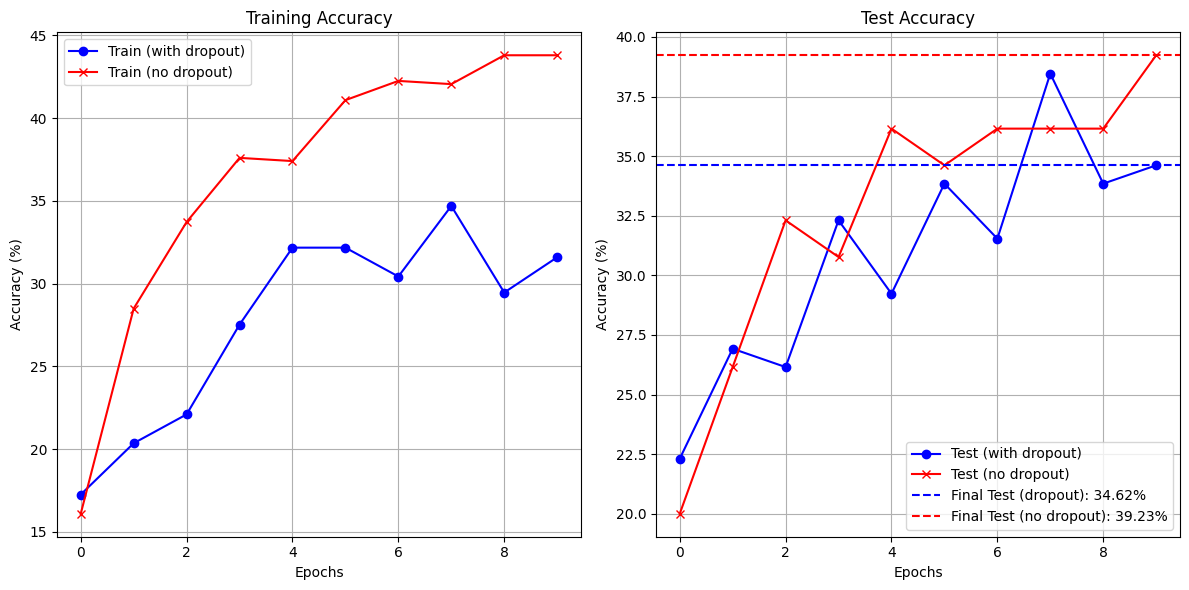


--- Impact of Dropout ---
Final Test Accuracy (With Dropout): 34.62%
Final Test Accuracy (Without Dropout): 39.23%
⚠️ Dropout may have reduced test accuracy; consider hyperparameter tuning.


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
%matplotlib inline
import torch.nn as nn
#from dog-breed-classifier-final.ipynb Prof lindell @60


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

#fixing__MACOSX
!unzip -o "/content/drive/MyDrive/DBIsubset.zip" -d "/content/"
!find /content/ -name "__MACOSX" -exec rm -rf {} +
!find /content/ -name ".*" -exec rm -rf {} +

#img normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(112),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load from my drive
dataset_path = '/content/DBIsubset'
dataset = ImageFolder(root=dataset_path, transform=transform)

#splitting train/test data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#constructing cnn with given structuree
#resource to learn about batch and pooling:
#"https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216"
class SimpleDBiCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SimpleDBiCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc_layers = nn.Sequential(
            nn.Linear(8 * 28 * 28, 32),
            nn.ReLU(),
            self.dropout,
            nn.Linear(32, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    train_accuracy, test_accuracy = [], []

    for epoch in range(epochs):

        #training
        model.train()
        correct = 0
        total = 0

        for img, labels in train_loader:
            img, labels = img.to(device), labels.to(device)
            to_return = model(img)

            loss = criterion(to_return, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(to_return, 1)
            total += labels.size(0)
            correct += torch.sum(preds == labels).item()

        train_acc = 100 * correct / total
        train_accuracy.append(train_acc)

        #testing the trained models
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for img, labels in test_loader:
                img, labels = img.to(device), labels.to(device)
                to_return = model(img)
                _, preds = torch.max(to_return, 1)
                total += labels.size(0)
                correct += torch.sum(preds == labels).item()

        test_acc = 100 * correct / total
        test_accuracy.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} => Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        scheduler.step()


    final_test_acc = test_accuracy[-1]

    return train_accuracy, test_accuracy, final_test_acc


num_classes = len(dataset.classes)

#w dropout
model_dropout = SimpleDBiCNN(num_classes=num_classes, dropout_rate=0.5).to(device)
train_acc_dropout, test_acc_dropout, final_test_acc_dropout = train_model(model_dropout, train_loader, test_loader)

#w/o dropout
model_no_dropout = SimpleDBiCNN(num_classes=num_classes, dropout_rate=0.0).to(device)
train_acc_no_dropout, test_acc_no_dropout, final_test_acc_no_dropout = train_model(model_no_dropout, train_loader, test_loader)


plt.figure(figsize=(12, 6))

#plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_dropout, label='Train w dropout', color='blue', marker='o')
plt.plot(train_acc_no_dropout, label='Train w/o dropout', color='red', marker='x')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

#plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_acc_dropout, label='Test w dropout ', color='grey', marker='o')
plt.plot(test_acc_no_dropout, label='Test w/o dropout', color='black', marker='x')

#final test
plt.axhline(y=final_test_acc_dropout, color='blue', linestyle='--', label=f'Final Test (dropout): {final_test_acc_dropout:.2f}%')
plt.axhline(y=final_test_acc_no_dropout, color='red', linestyle='--', label=f'Final Test (no dropout): {final_test_acc_no_dropout:.2f}%')

plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#following piazza just train and test w/o validation @115
print("\n--- Impact of Dropout ---")
print(f"Final Test Accuracy (With Dropout): {final_test_acc_dropout:.2f}%")
print(f"Final Test Accuracy (Without Dropout): {final_test_acc_no_dropout:.2f}%")
if final_test_acc_dropout > final_test_acc_no_dropout:
    print("Dropout helped improve generalization on the test set.")
else:
    print("Dropout may have reduced test accuracy; consider hyperparameter tuning.")
